Code repurposed from Kaggle [https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-cryptocurrencies]

## import dependencies

In [1]:
import pandas as pd
import pandas_datareader as web
import numpy as np
from pathlib import Path
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

## load and inspect data

In [2]:
crypto_currency = 'ETH'
against_currency = 'USD'

start = dt.datetime(2014,1,1)
end = dt.datetime.now()

base_df = web.DataReader(f'{crypto_currency}-{against_currency}', 'yahoo', start, end)
base_df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-08-06,3.536610,2.521120,2.831620,2.772120,1.643290e+05,2.772120
2015-08-07,2.798810,0.714725,2.793760,0.753325,6.741880e+05,0.753325
2015-08-08,0.879810,0.629191,0.706136,0.701897,5.321700e+05,0.701897
2015-08-09,0.729854,0.636546,0.713989,0.708448,4.052830e+05,0.708448
2015-08-10,1.131410,0.663235,0.708087,1.067860,1.463100e+06,1.067860
...,...,...,...,...,...,...
2021-06-14,2639.229248,2515.153076,2587.762695,2610.936768,2.900528e+10,2610.936768
2021-06-15,2554.628906,2354.350586,2544.864746,2367.663574,2.410193e+10,2367.663574
2021-06-16,2457.175537,2312.301514,2367.306396,2372.001953,2.187163e+10,2372.001953


In [3]:
base_df['Spread'] = base_df.High - base_df.Low
base_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2140 entries, 2015-08-06 to 2021-06-19
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       2140 non-null   float64
 1   Low        2140 non-null   float64
 2   Open       2140 non-null   float64
 3   Close      2140 non-null   float64
 4   Volume     2140 non-null   float64
 5   Adj Close  2140 non-null   float64
 6   Spread     2140 non-null   float64
dtypes: float64(7)
memory usage: 133.8 KB


## Plot the closing value of Dogecoin over time

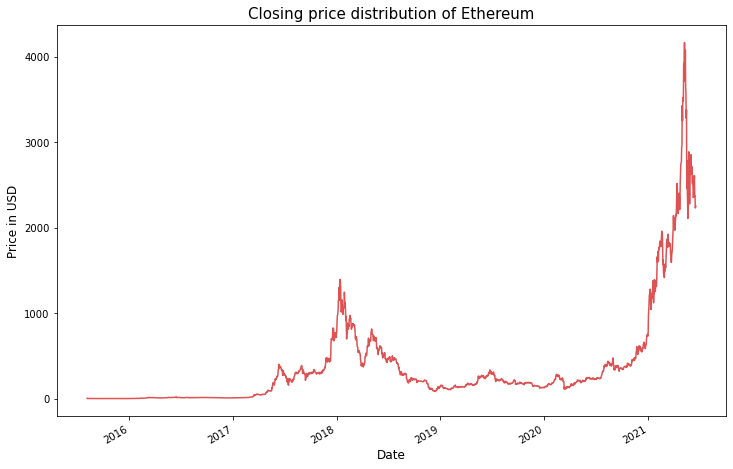

In [4]:
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(12,8))

sns.lineplot(y = base_df.Close.values, x=base_df.index.values, alpha=0.8, color=color[3])
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y.%m.%d'))
fig.autofmt_xdate()
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price in USD', fontsize=12)
plt.title("Closing price distribution of Ethereum", fontsize=15)
plt.show()

## Candlestick chart

In [5]:
import matplotlib.ticker as mticker
import mplfinance as mpf

#base_df['Date_mpl'] = base_df['Date'].apply(lambda x: mdates.date2num(x))

temp_base_df = base_df.copy(deep=False)
#temp_base_df = temp_base_df.set_index(['Date'])
temp_base_df = temp_base_df.drop(['Spread'], axis=1)
temp_base_df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-08-06,3.536610,2.521120,2.831620,2.772120,1.643290e+05,2.772120
2015-08-07,2.798810,0.714725,2.793760,0.753325,6.741880e+05,0.753325
2015-08-08,0.879810,0.629191,0.706136,0.701897,5.321700e+05,0.701897
2015-08-09,0.729854,0.636546,0.713989,0.708448,4.052830e+05,0.708448
2015-08-10,1.131410,0.663235,0.708087,1.067860,1.463100e+06,1.067860
...,...,...,...,...,...,...
2021-06-14,2639.229248,2515.153076,2587.762695,2610.936768,2.900528e+10,2610.936768
2021-06-15,2554.628906,2354.350586,2544.864746,2367.663574,2.410193e+10,2367.663574
2021-06-16,2457.175537,2312.301514,2367.306396,2372.001953,2.187163e+10,2372.001953


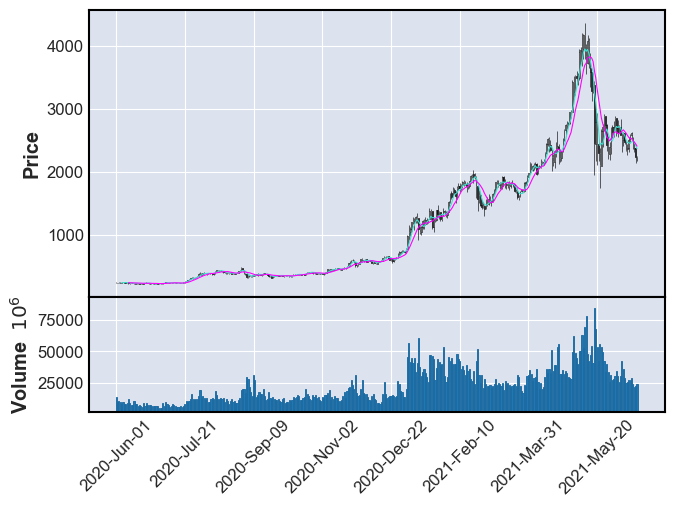

In [6]:
mpf.plot(temp_base_df.loc['2020-6-1':], type='candle', mav=(5,10), volume=True)

## Future Price Prediction

In [7]:
from fbprophet import Prophet

In [8]:
base_df

,High,Low,Open,Close,Volume,Adj Close,Spread
Date,,,,,,,
2015-08-06,3.536610,2.521120,2.831620,2.772120,1.643290e+05,2.772120,1.015490
2015-08-07,2.798810,0.714725,2.793760,0.753325,6.741880e+05,0.753325,2.084085
2015-08-08,0.879810,0.629191,0.706136,0.701897,5.321700e+05,0.701897,0.250619
2015-08-09,0.729854,0.636546,0.713989,0.708448,4.052830e+05,0.708448,0.093308
2015-08-10,1.131410,0.663235,0.708087,1.067860,1.463100e+06,1.067860,0.468175
...,...,...,...,...,...,...,...
2021-06-14,2639.229248,2515.153076,2587.762695,2610.936768,2.900528e+10,2610.936768,124.076172
2021-06-15,2554.628906,2354.350586,2544.864746,2367.663574,2.410193e+10,2367.663574,200.278320
2021-06-16,2457.175537,2312.301514,2367.306396,2372.001953,2.187163e+10,2372.001953,144.874023


In [9]:
price_predict_df = base_df['Close'].copy(deep=False).reset_index()
price_predict_df.columns = ["ds", "y"]
price_predict_df = price_predict_df[price_predict_df['ds']>'2020-6-1']
price_predict_df

,ds,y
1761,2020-06-02,244.179321
1762,2020-06-03,244.426392
1763,2020-06-04,241.221985
1764,2020-06-05,241.931320
1765,2020-06-06,245.167252
...,...,...
2135,2021-06-14,2610.936768
2136,2021-06-15,2367.663574
2137,2021-06-16,2372.001953
2138,2021-06-17,2231.733154


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
380,2021-06-22,2967.208637,2627.230711,3297.595334
381,2021-06-23,2981.553489,2648.292427,3333.919670
382,2021-06-24,2963.197429,2617.536212,3302.634815
383,2021-06-25,2983.439160,2624.461546,3315.214809
384,2021-06-26,2976.620807,2646.069019,3315.111038


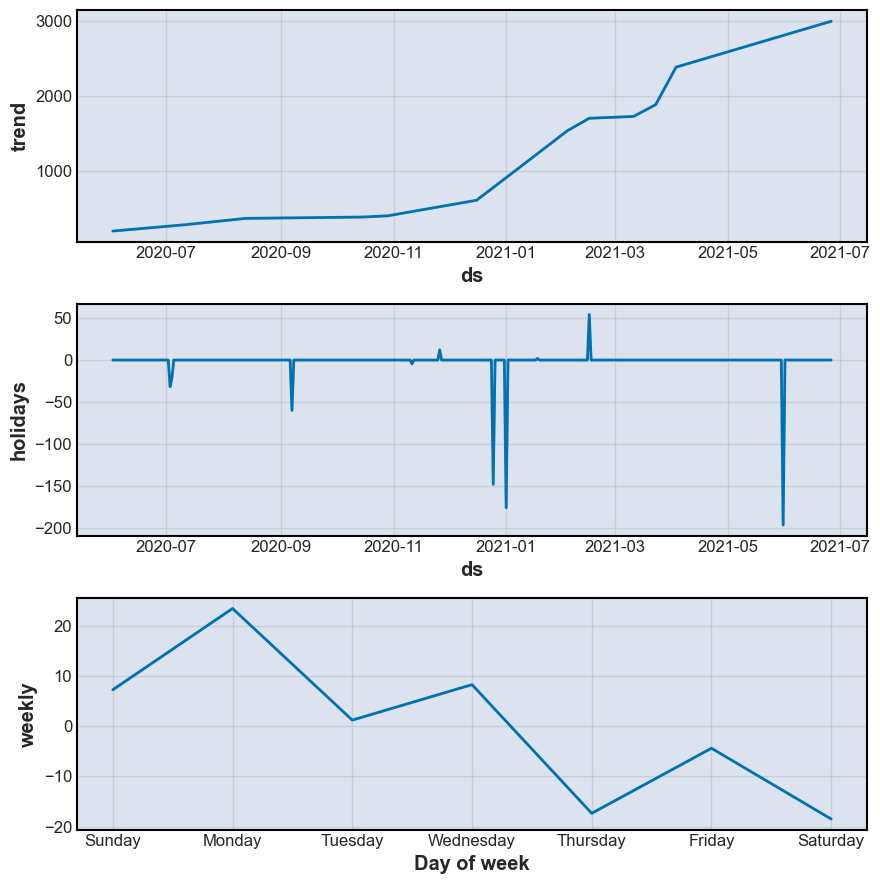

In [10]:
m = Prophet(changepoint_prior_scale=.7)
m.add_country_holidays(country_name='US')
m.fit(price_predict_df);
m.train_holiday_names

future = m.make_future_dataframe(periods=7)

forecast = m.predict(future)
fig = m.plot_components(forecast)

forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

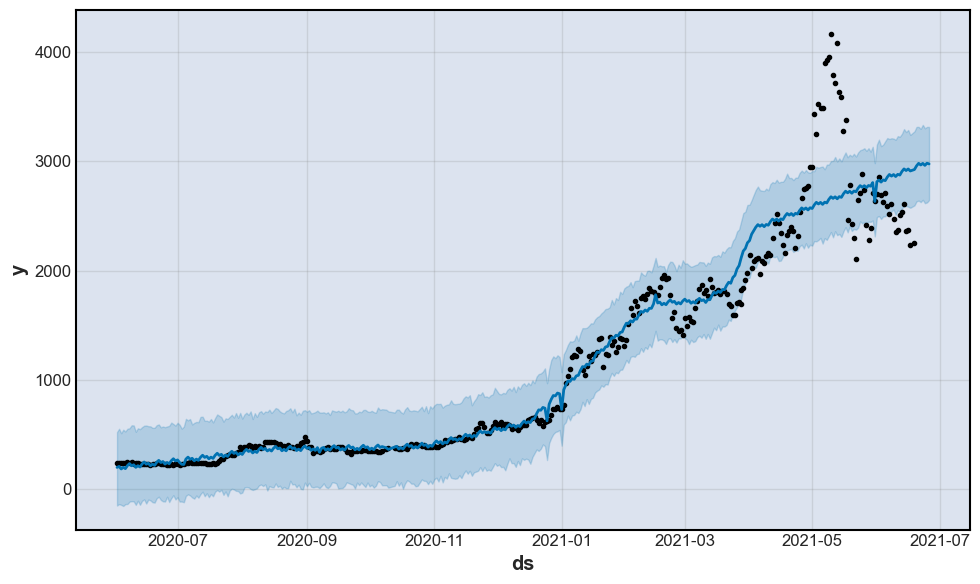

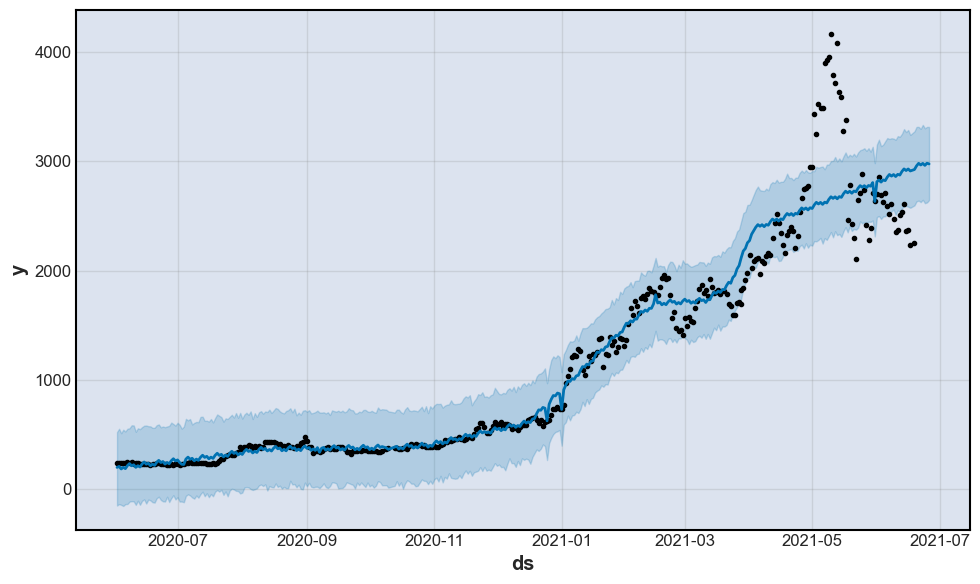

In [11]:
m.plot(forecast)

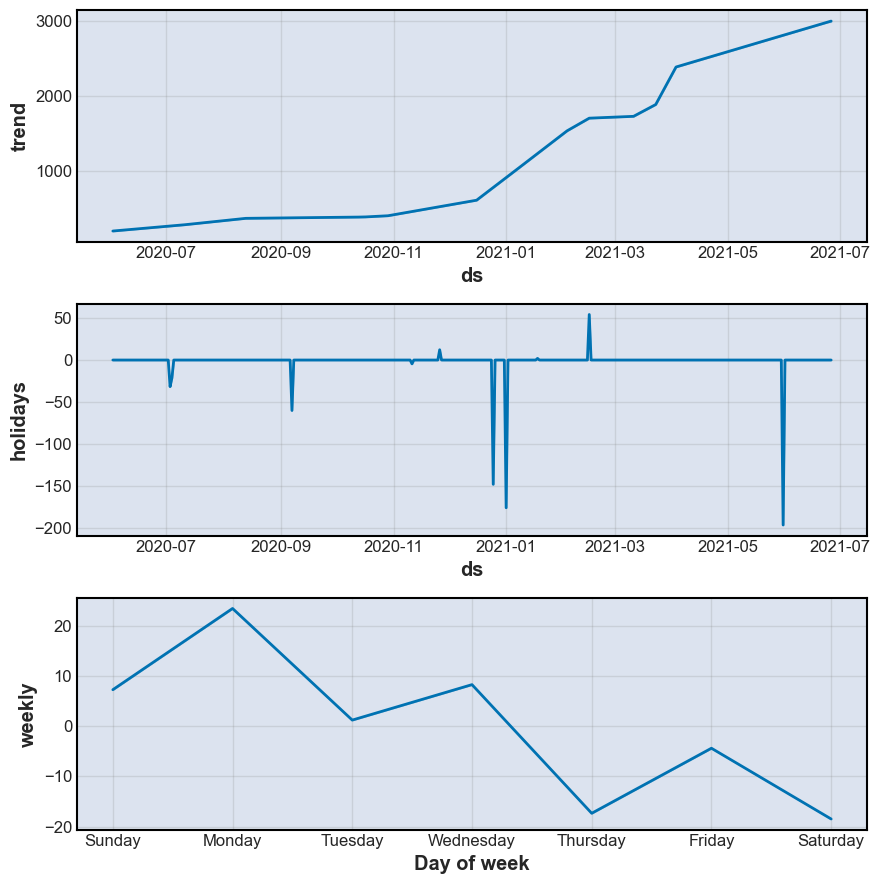

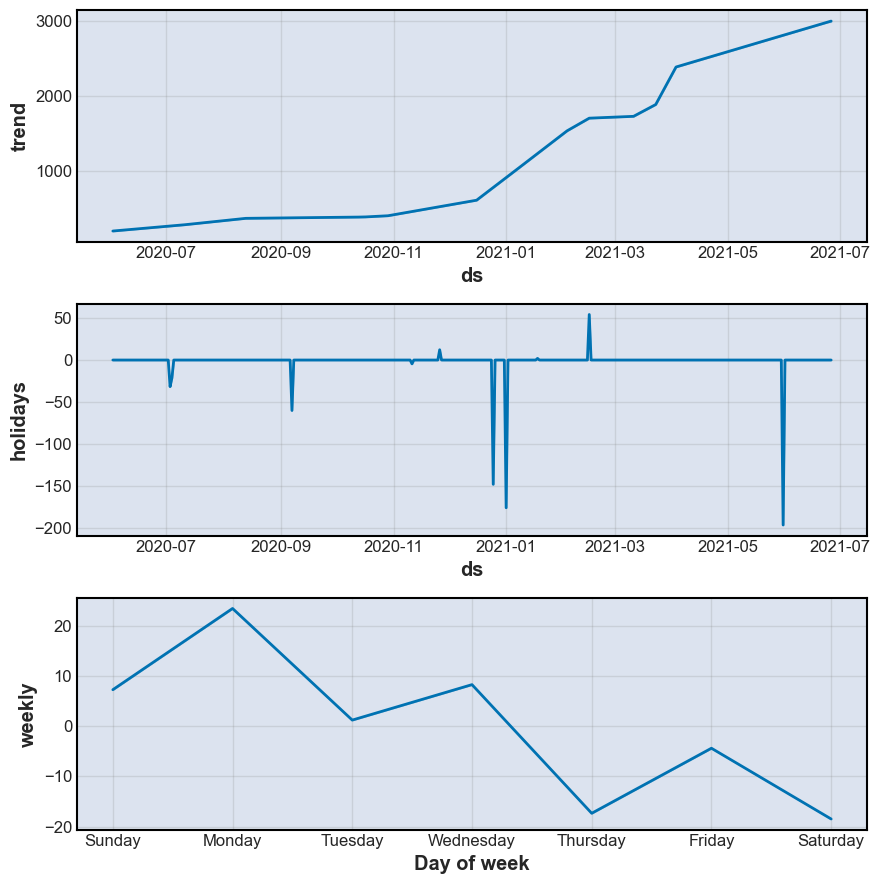

In [12]:
m.plot_components(forecast)